# Create network from GPM transport data
NEED TO RE-RUN THE GEOFABRIK CODE WITH THE CORRECT EPSG!!!

In [1]:
import shapely.wkb
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

plt.rcParams['figure.figsize'] = (15, 15)

## Testing R5Py

In [2]:
# Load Grid (= origins and destinations)
OD = pd.read_csv("./data/processed/GPM_grid.csv")
col_tokeep = ['geometry', 'CODE_IRIS']
OD["geometry"] = OD.apply(lambda x: shapely.wkt.loads(x.centroid), axis = 1)
OD_gdf = gpd.GeoDataFrame(OD, geometry = "geometry")[col_tokeep].reset_index().rename(columns = {'index':'id'})

# pick a row as origin
origin = OD_gdf.loc[OD_gdf.index == 1]
origin

#create subset of destinations for testing purposes
OD_gdf_short = OD_gdf.head(50)

In [40]:
from r5py import TransportNetwork
import datetime
from r5py import TravelTimeMatrixComputer, TransitMode, LegMode

transport_network = TransportNetwork("./data/raw/GPM.pbf")

travel_time_matrix_computer = TravelTimeMatrixComputer(
    transport_network,
    origins=origin,
    destinations = OD_gdf,
    transport_modes=[LegMode.WALK],# LegMode.BICYCLE],#  LegMode.CAR], #car doens't work?
    max_time = datetime.timedelta(hours = 50))

travel_time_matrix = travel_time_matrix_computer.compute_travel_times()

In [41]:
travel_time_matrix.isna().sum() 
# total 25731 
#WalkBike NaN 9128 timedelta 2.5 hours, NaN 136 timedelta 5 hours - doesn't get better with 50hours
#Walkonly NaN 23715 timedelta 2.5 hours, NaN 15825 timedelta 5 hours, down to 175 with 50hours 
# 
# cars not working?!


from_id          0
to_id            0
travel_time    175
dtype: int64

In [42]:
travel_time_matrix.head()

,from_id,to_id,travel_time
0,1,0,8.0
1,1,1,0.0
2,1,2,9.0
3,1,3,14.0
4,1,4,4.0


# from here: old code, ignore!!!!!
## Buses

In [1]:
# # Getting the subsetted data
# bus_routes_GPM = gpd.read_file("data/geographical_data/bus_routes_GPM.geojson")
# bus_stops_GPM = gpd.read_file("data/geographical_data/bus_stops_GPM.geojson")

# ax = plt.axes()

# bus_routes_GPM.plot(ax=ax, linewidth = 0.1, cmap = 'viridis')
# bus_stops_GPM.plot(ax=ax, cmap = 'viridis', markersize=1)


# bus_stops_GPM["lat"]=bus_stops_GPM['geometry'].y
# bus_stops_GPM["lon"]=bus_stops_GPM['geometry'].x

Problem: I have all stops and all lines, but they are not connected to each other and I have no clue of the distance between stops. 
For now I'll always work on one line to test stuff out and if succesful try to generalize it to the whole dataframe

In [3]:
# #--- Adding edges from distance matrix (QGIS created)
# distance_matrix = pd.DataFrame(gpd.read_file("data/geographical_data/distance_matrix.geojson"))
# distance_matrix = distance_matrix.drop(columns = 'geometry')
# distance_matrix

# #--- Creating a networkx graph 

# G = nx.Graph()

# # Add nodes = bus stops 
# for i, row in bus_stops_GPM.iterrows():
#             G.add_node(row['arrid'], pos=[row['lon'],row['lat']]) # add all nodes from id        
# pos=nx.get_node_attributes(G,'pos')

# # Add edges = straight lines between stops 
# edges = distance_matrix
# G = nx.from_pandas_edgelist(
#     edges,
#     source = 'InputID',
#     target = 'TargetID',
#     edge_attr=["Distance"],
#     create_using=nx.MultiGraph(),
# )

# # Plot
# nx.draw(G, pos=pos, node_size = 1)

In [4]:
#--- Cleaning up the dataframes
bus_routes_GPM.reset_index(inplace=True, drop=True)
bus_stops_GPM.reset_index(inplace=True, drop=True)
col_tokeep_stops = ['arrid', 'arrname', 'geometry', 'lat', 'lon']
bus_stops_GPM = bus_stops_GPM[col_tokeep_stops]
col_tokeep_routes = ['id', 'tags', 'geometry']
bus_routes_GPM = bus_routes_GPM[col_tokeep_routes]

In [5]:
#--- Connect stops to the nearest route
# IS THIS THING ACCURATE???

bus_routes_GPM_exploded = bus_routes_GPM.explode(index_parts = False).reset_index()
bus_all_GPM = gpd.sjoin_nearest(bus_stops_GPM, bus_routes_GPM) 
bus_all_GPM.head()

/Users/auriane/opt/miniconda3/envs/gds/lib/python3.8/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,arrid,arrname,geometry,lat,lon,index_right,id,tags
0,36381,Georges Demésy,POINT (2.55074 48.82282),48.822820,2.550741,204,8381278385,"{'colour': '#dc9600', 'network:wikidata': 'Q47..."
34,484464,Gare de Villiers-sur-Marne,POINT (2.54331 48.82356),48.823556,2.543312,204,8381278385,"{'colour': '#dc9600', 'network:wikidata': 'Q47..."
35,40003,Villiers-sur-Marne - Le Plessis-Trévise RER,POINT (2.54403 48.82378),48.823784,2.544032,204,8381278385,"{'colour': '#dc9600', 'network:wikidata': 'Q47..."
36,36409,Courts Sillons,POINT (2.54632 48.82714),48.827138,2.546318,204,8381278385,"{'colour': '#dc9600', 'network:wikidata': 'Q47..."
37,484463,Gare de Villiers-sur-Marne,POINT (2.54331 48.82369),48.823691,2.543310,204,8381278385,"{'colour': '#dc9600', 'network:wikidata': 'Q47..."


/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_32307/2357304085.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_209['dist_to_next_stop'][i] = distance.distance(stop1, stop2).km


,arrid,arrname,geometry,lat,lon,index_right,id,tags,dist_to_next_stop
0,472763,Villiers-sur-Marne - Le Plessis-Trévise RER,POINT (2.54334 48.82379),48.823790,2.543337,1419,12910408610,"{'colour': '#00a092', 'network:wikidata': 'Q47...",0.017467
1,26036,Villiers-sur-Marne - Le Plessis-Trévise RER,POINT (2.54355 48.82385),48.823854,2.543554,1419,12910408610,"{'colour': '#00a092', 'network:wikidata': 'Q47...",0.023773
2,36382,Villiers-sur-Marne - Le Plessis-Trévise RER,POINT (2.54385 48.82394),48.823936,2.543853,1419,12910408610,"{'colour': '#00a092', 'network:wikidata': 'Q47...",0.437010
3,480995,Georges Demésy,POINT (2.54969 48.82317),48.823167,2.549689,1419,12910408610,"{'colour': '#00a092', 'network:wikidata': 'Q47...",0.491684
4,481020,Gros Chêne,POINT (2.55618 48.82426),48.824261,2.556177,1419,12910408610,"{'colour': '#00a092', 'network:wikidata': 'Q47...",0.010442


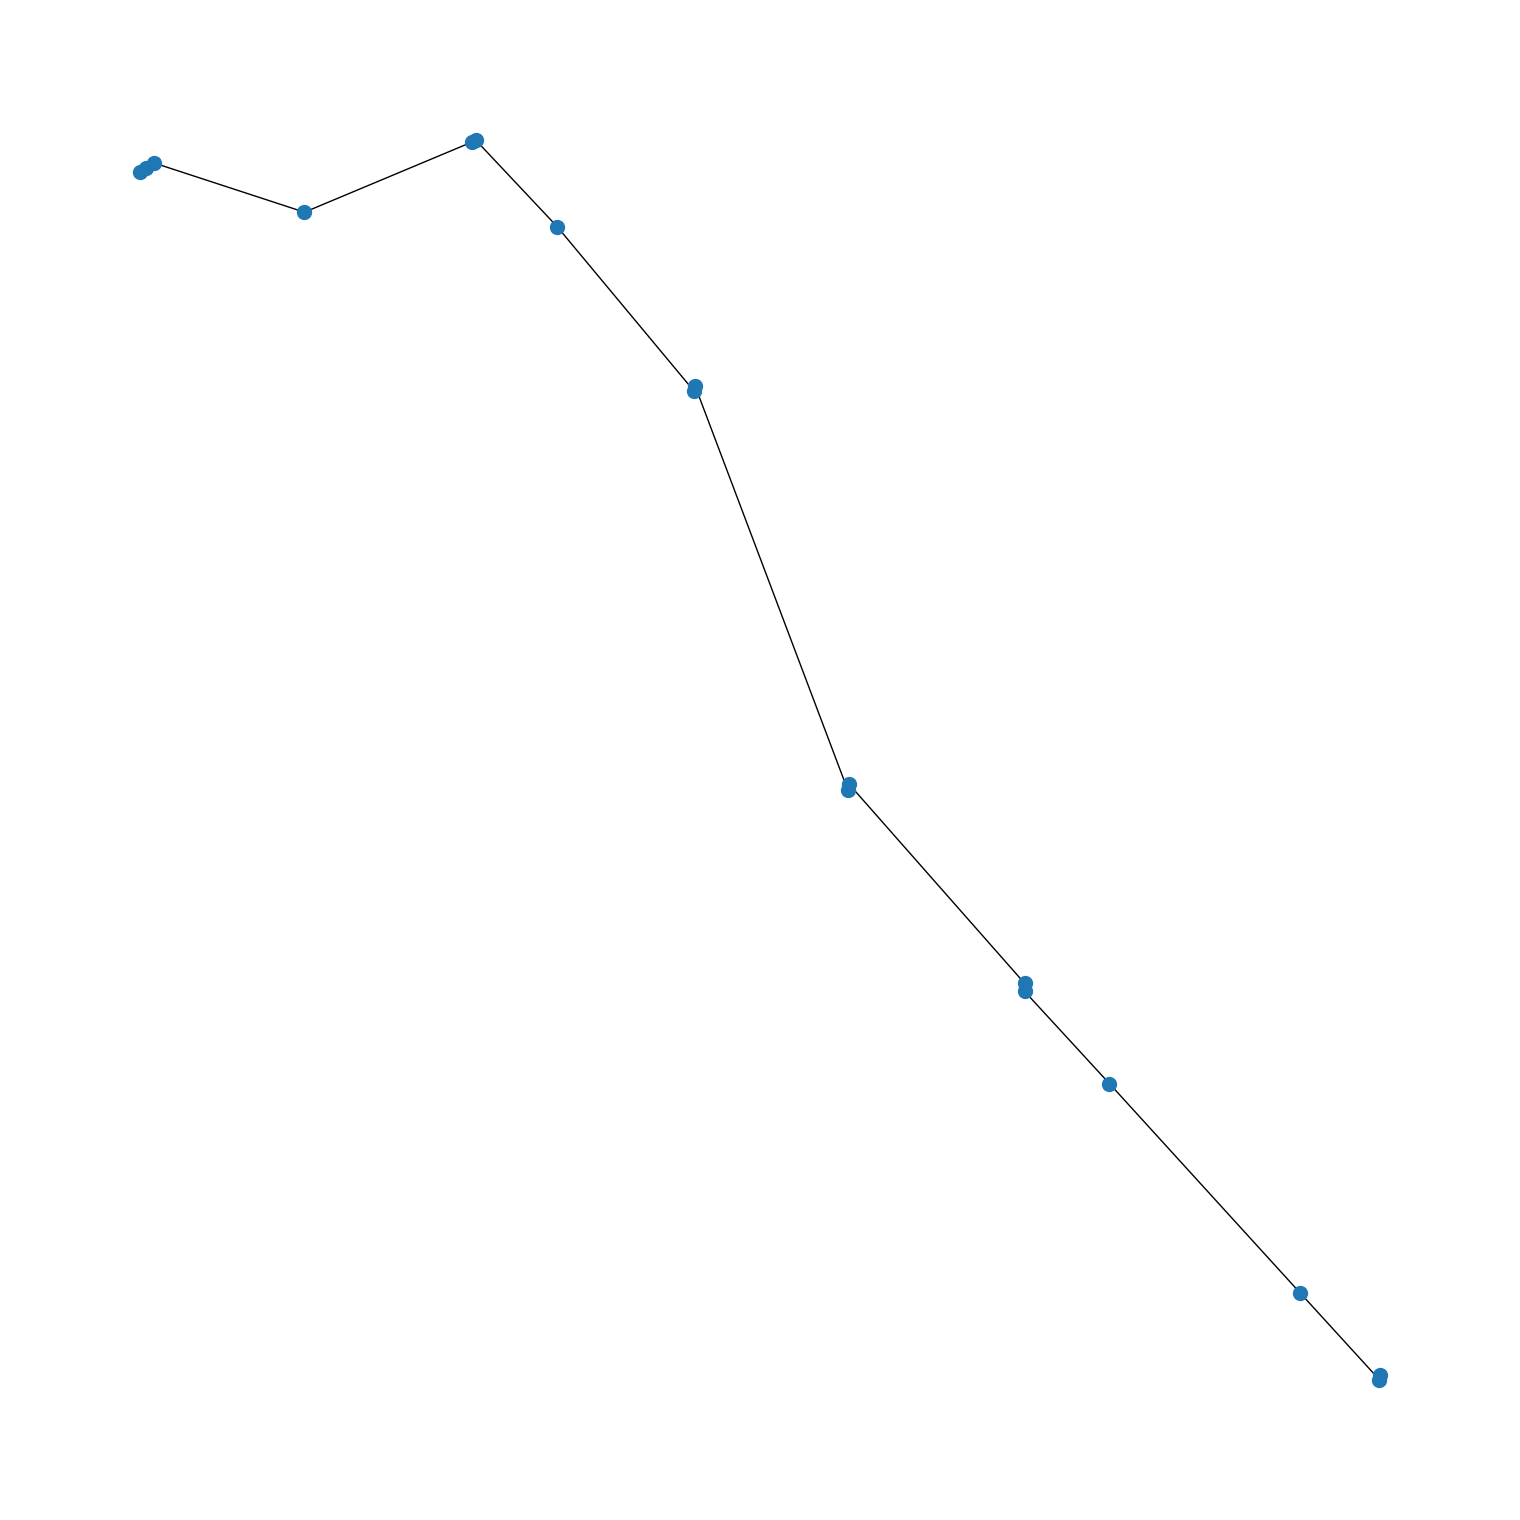

In [6]:
#--- Working with only one line for now
line_209 = bus_all_GPM.loc[bus_all_GPM['id']==12910408610]

#--- Create a graph
F = nx.Graph()

# Add nodes = bus stops 
for i, row in line_209.iterrows():
        F.add_node(row['arrid'], pos=[row['lon'],row['lat']]) # add all nodes from id

# Add edges = straight lines between stops 
#calculate distance between points 
sorted_209 = line_209.sort_values(by=['lon','lat']).reset_index(drop = True)
sorted_209['dist_to_next_stop']=0

from geopy import distance

for i,row in sorted_209.iterrows():
    if i<len(sorted_209)-1:
        stop1 = (row['lat'], row['lon'])
        stop2 = (sorted_209['lat'][i+1], sorted_209['lon'][i+1])
        sorted_209['dist_to_next_stop'][i] = distance.distance(stop1, stop2).km

for i,row in sorted_209.iterrows():
    if i<len(sorted_209)-1:
        F.add_edge(row['arrid'], sorted_209['arrid'][i+1], weight = row['dist_to_next_stop'])
        last = sorted_209['arrid'][i+1]
# Plot
pos = nx.get_node_attributes(F,'pos')
nx.draw(F, pos=pos, node_size = 100)
sorted_209.head()

(Accurately?) connected stops to lines, still need to deal with duplicates and improve the distance calculation (beeline is still not accurately calculated, need to make it go through streets later on as well). 

In [7]:
#--- Making a unique stop out of all the different IDs with the same stop name 
#--- Working with only one line for now

line_209
test_209 = gpd.GeoDataFrame(line_209.groupby(['arrname']).agg(tuple).applymap(list).reset_index())
for i, row in test_209.iterrows():
    for col in ['lat', 'lon']:
        test_209[col][i] = np.average(test_209[col][i])
    row['arrid'] = list(set(row['arrid']))[0]
    row['geometry'] = list(row['geometry'])[0]
    row['id'] = row['id']
test_209.head()

,arrname,arrid,geometry,lat,lon,index_right,id,tags
0,Buffon,481009,POINT (2.59126 48.80506),48.805018,2.591258,"[1419, 1419]","[12910408610, 12910408610]","[{'colour': '#00a092', 'network:wikidata': 'Q4..."
1,Cimetière,481012,POINT (2.58818 48.80633),48.806334,2.588177,[1419],[12910408610],"[{'colour': '#00a092', 'network:wikidata': 'Q4..."
2,François Mansard,481015,POINT (2.58081 48.80959),48.809591,2.580812,[1419],[12910408610],"[{'colour': '#00a092', 'network:wikidata': 'Q4..."
3,Georges Demésy,480995,POINT (2.54969 48.82317),48.823167,2.549689,[1419],[12910408610],"[{'colour': '#00a092', 'network:wikidata': 'Q4..."
4,Gros Chêne,481020,POINT (2.55618 48.82426),48.824275,2.556245,"[1419, 1419]","[12910408610, 12910408610]","[{'colour': '#00a092', 'network:wikidata': 'Q4..."


<AxesSubplot: >

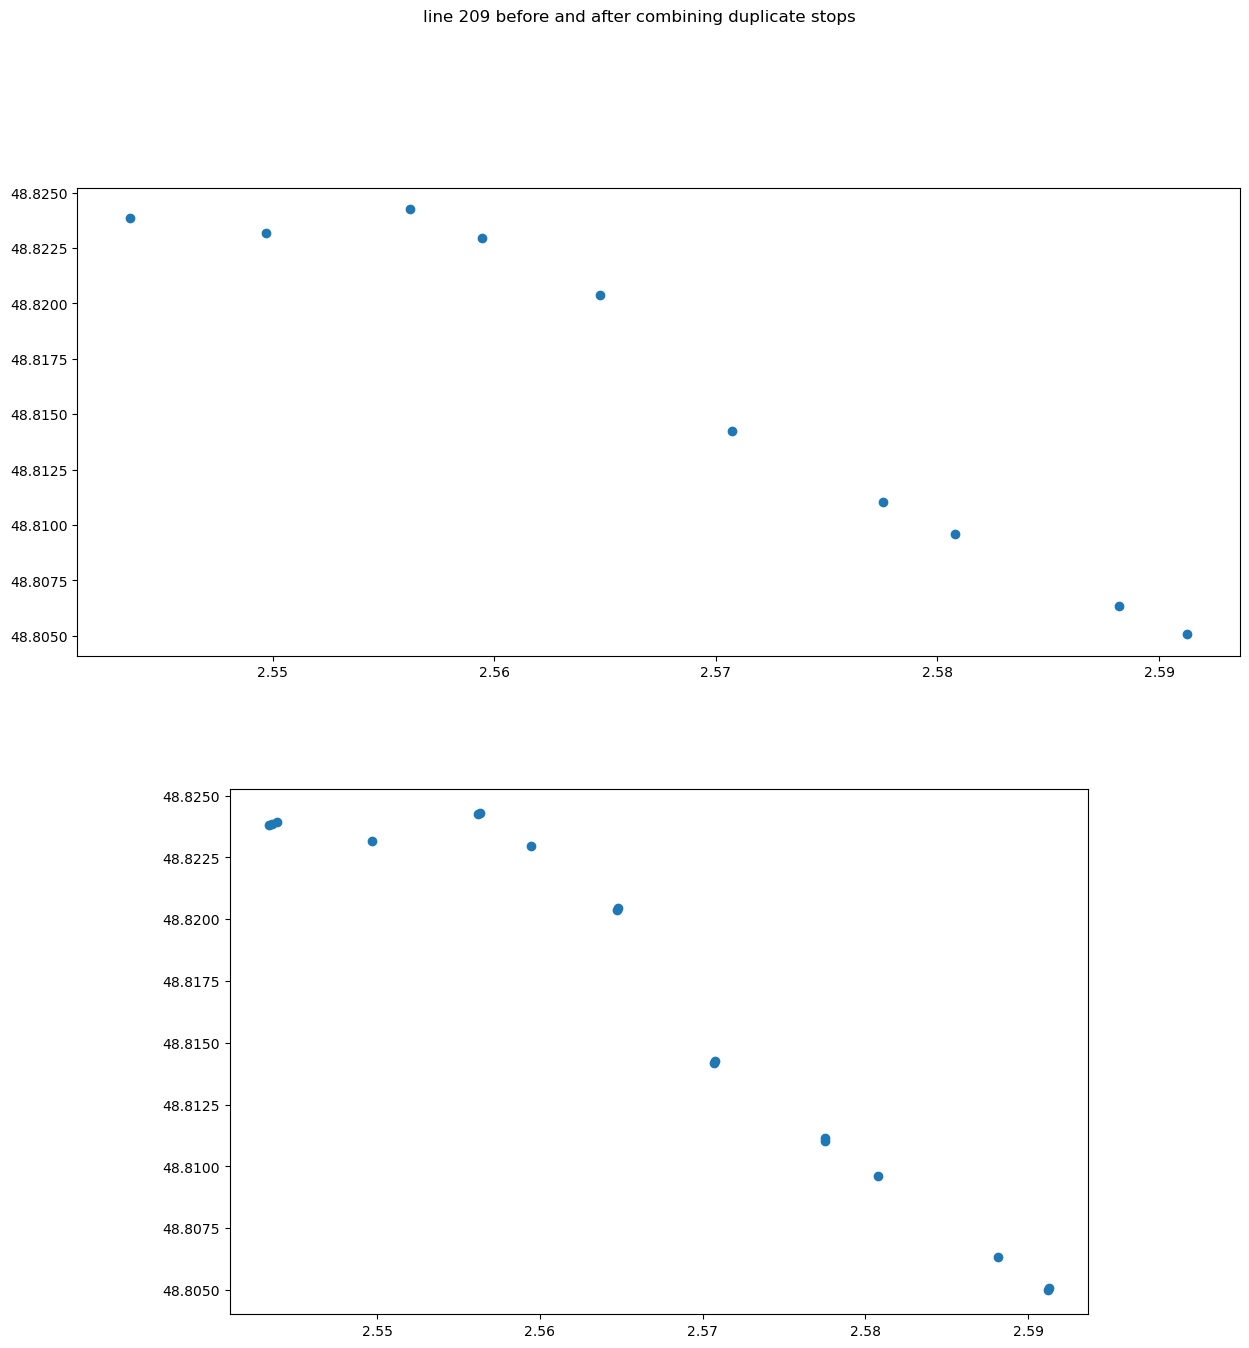

In [8]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('line 209 before and after combining duplicate stops')
line_209.plot(ax=ax2)
test_209.plot(ax=ax1)

Duplicate stops are taken care of, now it's all about that distance, which should wait until I have car data. Until then, let's try to build a network with distances out of line 209 and if that works (which it should) we try to apply it to the whole network!

/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_32307/1963961156.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_209['dist_to_next_stop'][i] = distance.distance(stop1, stop2).km


,arrname,arrid,geometry,lat,lon,index_right,id,tags,dist_to_next_stop
0,Villiers-sur-Marne - Le Plessis-Trévise RER,26036,POINT (2.54355 48.82385),48.82386,2.543581,"[1419, 1419, 1419]","[12910408610, 12910408610, 12910408610]","[{'colour': '#00a092', 'network:wikidata': 'Q4...",0.455088
1,Georges Demésy,480995,POINT (2.54969 48.82317),48.823167,2.549689,[1419],[12910408610],"[{'colour': '#00a092', 'network:wikidata': 'Q4...",0.496899
2,Gros Chêne,481020,POINT (2.55618 48.82426),48.824275,2.556245,"[1419, 1419]","[12910408610, 12910408610]","[{'colour': '#00a092', 'network:wikidata': 'Q4...",0.278560
3,Maréchal Mortier,481022,POINT (2.55946 48.82294),48.822942,2.559457,[1419],[12910408610],"[{'colour': '#00a092', 'network:wikidata': 'Q4...",0.480416
4,Pasteur,480996,POINT (2.56475 48.82038),48.820421,2.56477,"[1419, 1419]","[12910408610, 12910408610]","[{'colour': '#00a092', 'network:wikidata': 'Q4...",0.817263


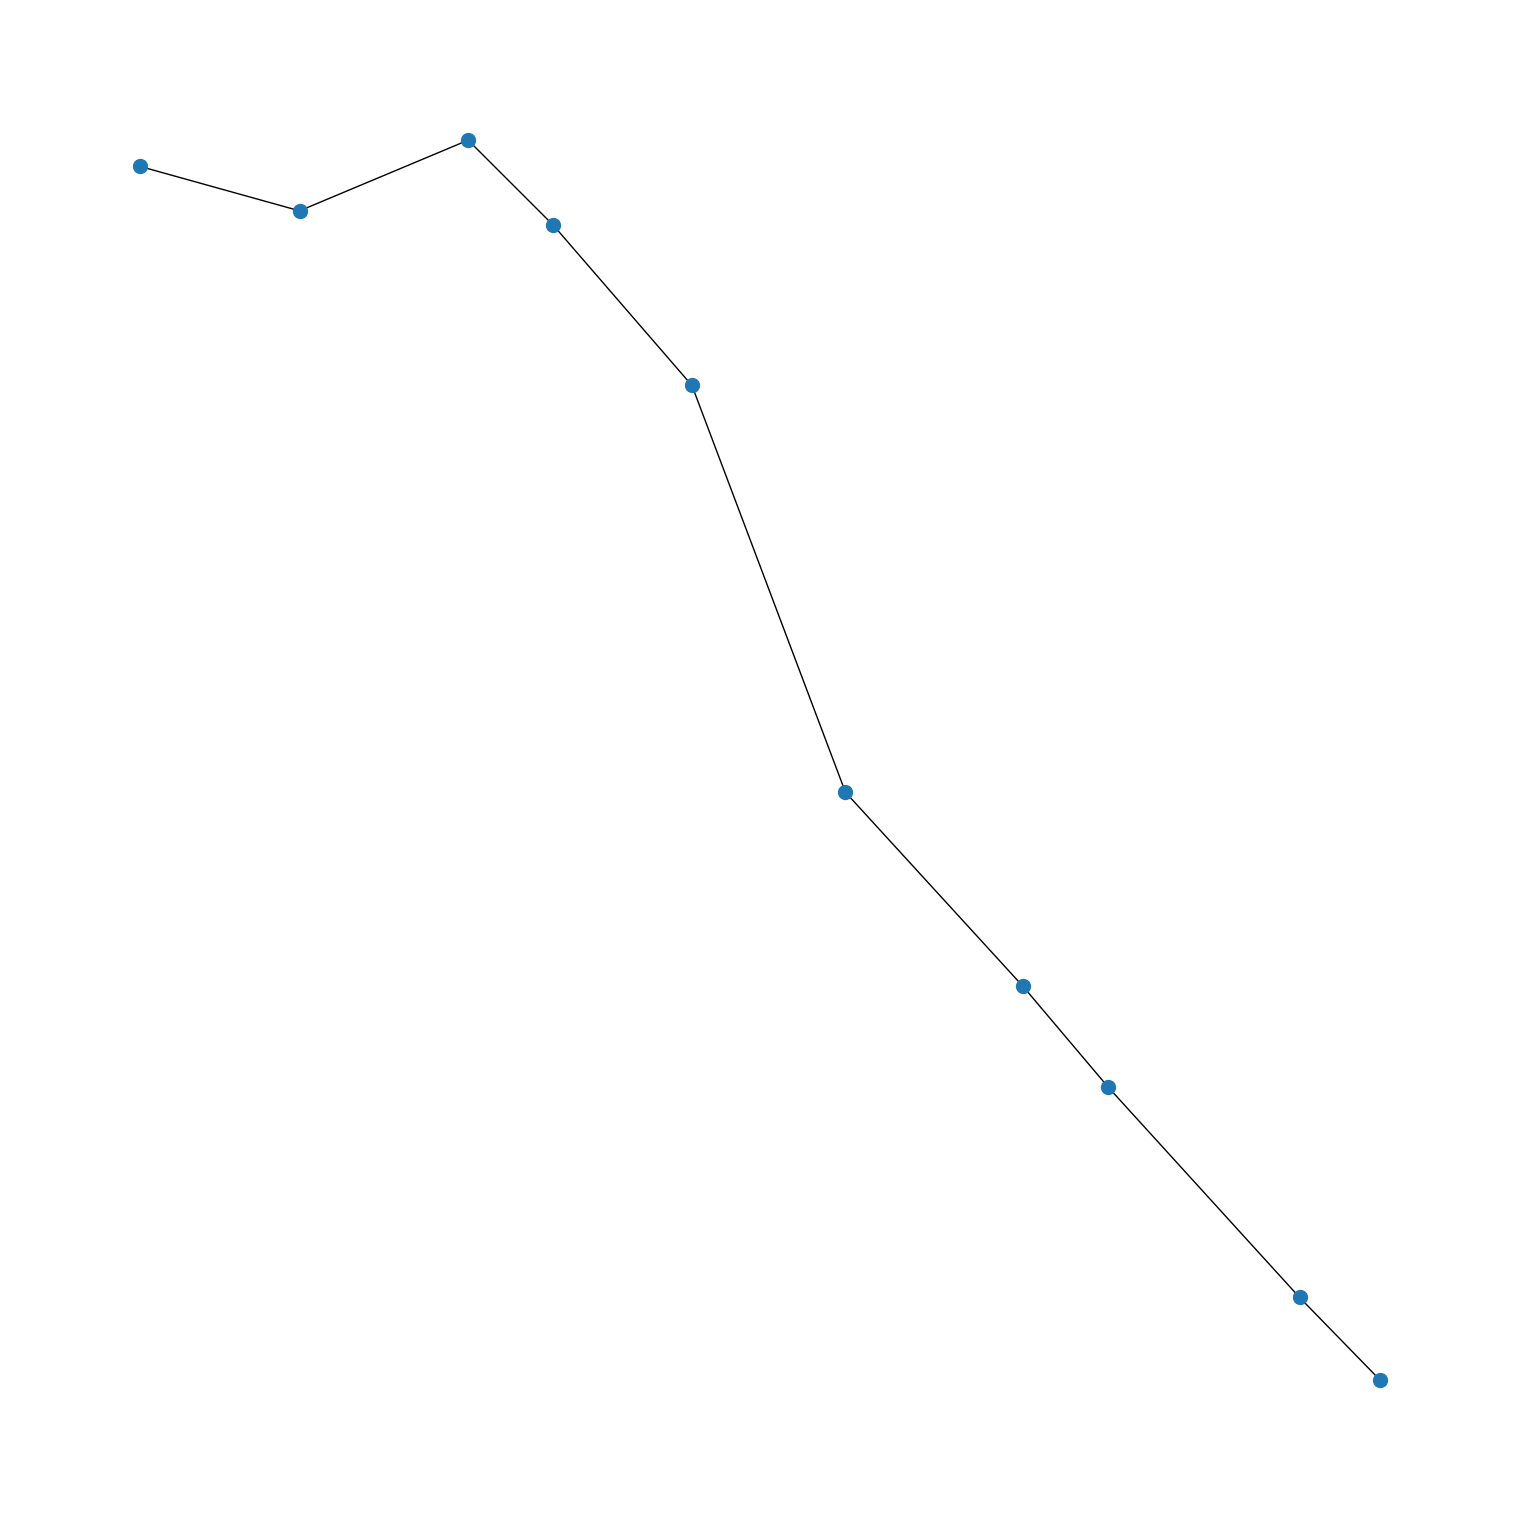

In [9]:
line_209 = test_209

#--- Create a graph
K = nx.Graph()

# Add nodes = bus stops 
for i, row in line_209.iterrows():
        K.add_node(row['arrid'], pos=[row['lon'],row['lat']]) 

# Add edges = straight lines between stops 
#calculate distance between points 
sorted_209 = line_209.sort_values(by=['lon','lat']).reset_index(drop = True)
sorted_209['dist_to_next_stop']=0

from geopy import distance

for i,row in sorted_209.iterrows():
    if i<len(sorted_209)-1:
        stop1 = (row['lat'], row['lon'])
        stop2 = (sorted_209['lat'][i+1], sorted_209['lon'][i+1])
        sorted_209['dist_to_next_stop'][i] = distance.distance(stop1, stop2).km

for i,row in sorted_209.iterrows():
    if i<len(sorted_209)-1:
        K.add_edge(row['arrid'], sorted_209['arrid'][i+1], weight = row['dist_to_next_stop'])
        last = sorted_209['arrid'][i+1]
# Plot
pos = nx.get_node_attributes(K,'pos')
nx.draw(K, pos=pos, node_size = 100)
sorted_209.head()

In [22]:
#--- Make a unique stop out of all the different IDs with the same stop name 
bus_all_GPM_noduplicates = gpd.GeoDataFrame(bus_all_GPM.groupby(['arrname']).agg(tuple).applymap(list).reset_index())

for i, row in bus_all_GPM_noduplicates.iterrows():
    for col in ['lat', 'lon']:
        bus_all_GPM_noduplicates[col][i] = np.average(bus_all_GPM_noduplicates[col][i])
    row['arrid'] = list(set(row['arrid']))[0]
    row['geometry'] = list(row['geometry'])[0]


#--- Create a graph
J = nx.Graph()

# Add nodes = bus stops 
for i, row in bus_all_GPM_noduplicates.iterrows():
        J.add_node(row['arrid'], pos=[row['lon'],row['lat']]) 

# Add edges = straight lines between stops 
bus_all_GPM_noduplicates_sorted = bus_all_GPM_noduplicates.sort_values(by=['lon','lat']).reset_index(drop = True)

#calculate distance between points 
from geopy import distance
bus_all_GPM_noduplicates_sorted['dist_to_next_stop']=0
bus_all_GPM_noduplicates_sorted
# for i,row in bus_all_GPM_noduplicates_sorted.iterrows():
#     if i<len(bus_all_GPM_noduplicates_sorted)-1:
#         stop1 = (row['lat'], row['lon'])
#         stop2 = (bus_all_GPM_noduplicates_sorted['lat'][i+1], bus_all_GPM_noduplicates_sorted['lon'][i+1])
#         bus_all_GPM_noduplicates_sorted['dist_to_next_stop'][i] = distance.distance(stop1, stop2).km

        
# for i,row in bus_all_GPM_noduplicates_sorted.iterrows():
#     if i<len(bus_all_GPM_noduplicates_sorted)-1:
#         J.add_edge(row['arrid'], bus_all_GPM_noduplicates_sorted['arrid'][i+1], weight = row['dist_to_next_stop'])
#         last = bus_all_GPM_noduplicates_sorted['arrid'][i+1]
# Plot
# pos = nx.get_node_attributes(J,'pos')
# nx.draw(J, pos=pos, node_size = 1)

TypeError: unhashable type: 'list'

In [10]:
# #--- Combining bus stops and routes using overlay (UNNECESARY, DONE WITH SJOIN!)

# # Add buffer to bus stops
# bus_stops_GPM.to_crs(epsg = 2154)
# bus_stops_GPM['buffer']= bus_stops_GPM.buffer(0.00004922) #played around until I had the right number of stops
# col_tokeep = ['arrid', 'arrname', 'lat', 'lon', 'buffer']
# bus_stops_GPM_buffer = bus_stops_GPM[col_tokeep].set_geometry('buffer')
# bus_stops_GPM_buffer

# # Overlay buffered bus stops and bus routes 
# bus_all_GPM_exploded = gpd.overlay(bus_stops_GPM_buffer, bus_routes_GPM_exploded,
#                                    how='intersection', keep_geom_type=False) 



# #--- Create a network for one line of bus

# line_209 = bus_all_GPM_exploded.loc[bus_all_GPM_exploded['id']==12910408610]
# O = nx.Graph()

# #- Add nodes = bus stops 
# for i, row in line_209.iterrows():
#         O.add_node(row['arrid'], pos=[row['lon'],row['lat']]) # add all nodes from id
        


# #- Add edges = straight lines between stops 

# #calculate distance between points 
# from geopy import distance

# sorted_209 = line_209.sort_values(by=['lon','lat']).reset_index(drop = True)
# sorted_209['dist_to_next_stop']=0


# for i,row in sorted_209.iterrows():
#     if i<len(sorted_209)-1:
#         stop1 = (row['lat'], row['lon'])
#         stop2 = (sorted_209['lat'][i+1], sorted_209['lon'][i+1])
#         sorted_209['dist_to_next_stop'][i] = distance.distance(stop1, stop2).km


# for i,row in sorted_209.iterrows():
#     if i<len(sorted_209)-1:
#         O.add_edge(row['arrid'], sorted_209['arrid'][i+1], weight = row['dist_to_next_stop'])
#         last = sorted_209['arrid'][i+1]

# # Plot
# pos = nx.get_node_attributes(O,'pos')
# nx.draw(O, pos=pos, node_size = 100)

# TODO
- edges need to be divided by bus line and have that as an attribute
- create edges according to bus lines
- figure out length (needs connection to street network) 
- make it travel-able
- check epsg 